In [1]:
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn as nn
import torch

from sgan.losses import displacement_error, final_displacement_error
from sgan.losses import gan_g_loss, gan_d_loss, l2_loss
from sgan.data.loader import data_loader
from sgan.models import TrajectoryGenerator, TrajectoryDiscriminator
from sgan.utils import int_tuple, bool_flag, get_total_norm
from sgan.utils import relative_to_abs, get_dset_path
import train

from collections import defaultdict
from attrdict import AttrDict
from tqdm import tqdm
import numpy as np
import argparse
import logging
import random
import time
import sys
import os
import gc

torch.backends.cudnn.benchmark = True

parser = argparse.ArgumentParser()
FORMAT = '[%(levelname)s: %(filename)s: %(lineno)4d]: %(message)s'
logging.basicConfig(level=logging.INFO, format=FORMAT, stream=sys.stdout)
logger = logging.getLogger(__name__)

/opt/conda/envs/cuda_11_6/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import torchvision


torchvision.models.vit_b_32()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [2]:
def get_generator(checkpoint):
    args = AttrDict(checkpoint['args'])
    generator = TrajectoryGenerator(
        obs_len=args.obs_len,
        pred_len=args.pred_len,
        embedding_dim=args.embedding_dim,
        encoder_h_dim=args.encoder_h_dim_g,
        decoder_h_dim=args.decoder_h_dim_g,
        mlp_dim=args.mlp_dim,
        num_layers=args.num_layers,
        noise_dim=args.noise_dim,
        noise_type=args.noise_type,
        noise_mix_type=args.noise_mix_type,
        pooling_type=args.pooling_type,
        pool_every_timestep=args.pool_every_timestep,
        dropout=args.dropout,
        bottleneck_dim=args.bottleneck_dim,
        neighborhood_size=args.neighborhood_size,
        grid_size=args.grid_size,
        batch_norm=args.batch_norm)
    generator.load_state_dict(checkpoint['g_state'])
    generator.cuda()
    generator.train()
    return generator


def set_seed(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed)
    
set_seed()

In [3]:
# checkpoint = torch.load("models/sgan-p-models/eth_12_model.pt")
checkpoint = torch.load("models/sgan-models/eth_8_model.pt")
# checkpoint = torch.load("./S_hotel_eth_8_model.pt")
args = AttrDict(checkpoint['args'])

generator = get_generator(checkpoint)
if 'g_best_state' in args.keys():
    generator.load_state_dict(checkpoint['g_best_state'])
else:
    generator.load_state_dict(checkpoint['g_state'])
    
generator = generator.cuda().eval()



train_path = get_dset_path(args.dataset_name, 'train')
test_path = get_dset_path(args.dataset_name, 'test')

train_dset, train_loader = data_loader(args, train_path)
test_dset, test_loader = data_loader(args, test_path)


In [4]:
def evaluate_only_generator(generator, obs_traj, pred_traj_gt, obs_traj_rel, num_samples):
    with torch.no_grad():
        ade, fde = [], []

        for _ in range(num_samples):
            pred_traj_fake_rel = generator(obs_traj, obs_traj_rel, seq_start_end)
            pred_traj_fake = relative_to_abs(pred_traj_fake_rel, obs_traj[-1])
            
            ade.append(displacement_error(pred_traj_fake, pred_traj_gt, mode='raw'))
            fde.append(final_displacement_error(pred_traj_fake[-1], pred_traj_gt[-1], mode='raw'))

        ade_sum = evaluate_helper(ade, seq_start_end)
        fde_sum = evaluate_helper(fde, seq_start_end)

        
        return ade_sum, fde_sum

In [5]:
def evaluate_helper(error, seq_start_end):
    sum_ = 0
    error = torch.stack(error, dim=1)

    for (start, end) in seq_start_end:
        start = start.item()
        end = end.item()
        _error = error[start:end]
        _error = torch.sum(_error, dim=0)
        _error = torch.min(_error)
        sum_ += _error
    return sum_

In [6]:
optimizer_g = optim.Adam(generator.parameters(), lr=args.g_learning_rate)

from matplotlib import pyplot as plt
from tqdm import tqdm

ades = []
fdes = []
ades2 = []
fdes2 = []

results = []
for alpha in np.arange(0,1100,10):
    set_seed()
    loss_a = []
    loss_b = []

    pbar = tqdm(test_loader)
    
    for batch in pbar:
        batch = [tensor.cuda() for tensor in batch]
        (obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel, non_linear_ped, loss_mask, seq_start_end) = batch

        optimizer_g.zero_grad()
        #  ===================================================================
        set_seed()
        generator.train()
        obs_traj.requires_grad = True
        obs_traj_rel.requires_grad = True

        pred = generator(obs_traj, obs_traj_rel, seq_start_end)

        P = relative_to_abs(pred, obs_traj[-1])
        loss = torch.mean((pred - pred_traj_gt_rel) ** 2)
        loss.backward()

        #  ===================================================================
        if False:
            obs_traj_lrp = obs_traj - obs_traj.grad  * torch.abs(obs_traj) * alpha
        else:
            obs_traj_lrp = obs_traj
        obs_traj_rel_lrp = obs_traj_rel - obs_traj_rel.grad * torch.abs(obs_traj_rel) * alpha

        generator.eval()
        #  =================================================================== 
        ade, fde = evaluate_only_generator(generator, obs_traj, pred_traj_gt, obs_traj_rel, 5)
        ade2, fde2 = evaluate_only_generator(generator, obs_traj_lrp, pred_traj_gt, obs_traj_rel_lrp, 5)

        #  ===================================================================    
        ades.append(ade.item())
        fdes.append(fde.item())
        
        ades2.append(ade2.item())
        fdes2.append(fde2.item())

        pbar.set_postfix({
            "ade general" : sum(ades) / len(ades),
            "ade LRP" : sum(ades2) / len(ades2),
            "alpha" : alpha,
        })
        
    results.append(sum(ades2) / len(ades2))


100%|██████████| 4/4 [00:01<00:00,  3.30it/s, ade general=789, ade LRP=770, alpha=930]


100%|██████████| 4/4 [00:01<00:00,  3.10it/s, ade general=789, ade LRP=819, alpha=1090]


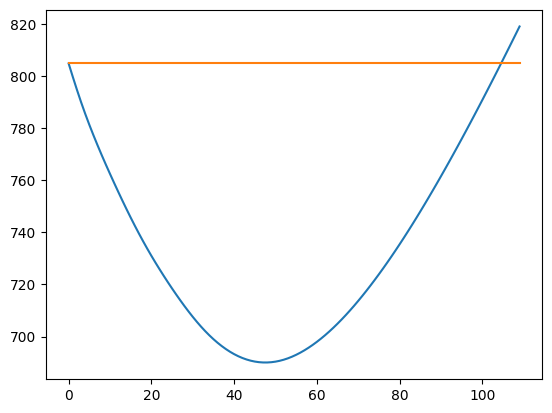

In [7]:
from matplotlib import pyplot as plt

plt.plot(results)
plt.plot([results[0]] * len(results))